Accuracy: 0.8764044943820225


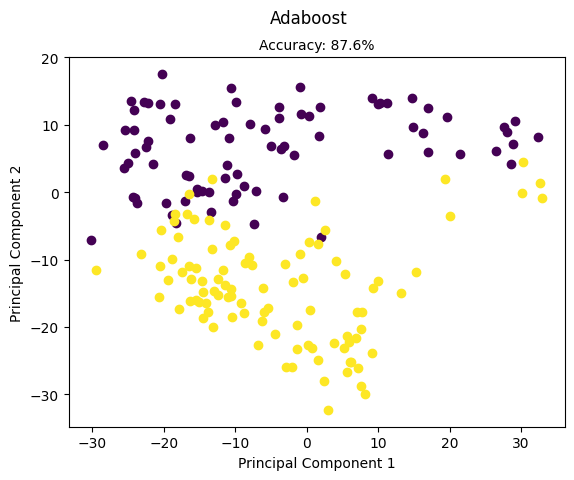

In [1]:
from __future__ import division, print_function
import numpy as np
import math
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from __future__ import division
import sys
from itertools import combinations_with_replacement

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))

    return variance

def calculate_std_dev(X):
    """ Calculate the standard deviations of the features in dataset X """
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    return X_std

class Plot():
    def __init__(self):
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):

        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        if not legend_labels is None:
            plt.legend(class_distr, legend_labels, loc=1)

        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()

class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None

class Adaboost():
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []
        self.clfs_alpha = []

    # Q2 Part 1.1 Adaboost.fit
    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')

            for feature_idx in range(n_features):
                feature_values = np.expand_dims(X[:, feature_idx], axis=1)
                unique_values = np.unique(feature_values)
                for threshold in unique_values:
                    p = 1
                    prediction = np.ones(n_samples)
                    prediction[X[:, feature_idx] < threshold] = -1

                    error = np.sum(w[y != prediction])

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_idx
                        min_error = error

            clf.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))

            predictions = np.ones(n_samples)
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            predictions[negative_idx] = -1
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            self.clfs.append(clf)
            self.clfs_alpha.append(clf.alpha)

    # Q2 Part 1.2 Adaboost.predict
    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for clf, alpha in zip(self.clfs, self.clfs_alpha):
            pred = np.ones(n_samples)
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            pred[negative_idx] = -1
            predictions += alpha * pred

        return np.sign(predictions)


def main():
    data = datasets.load_digits()
    X = data.data
    y = data.target

    digit1 = 1
    digit2 = 8
    idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
    y = data.target[idx]
    y[y == digit1] = -1
    y[y == digit2] = 1
    X = data.data[idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print ("Accuracy:", accuracy)

    Plot().plot_in_2d(X_test, y_pred, title="Adaboost", accuracy=accuracy)


if __name__ == "__main__":
    main()

Q2 Part 2

Accuracy for the above question is a variable in range 0.75 to 0.95.